In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy

# Calculating the Welch spectrum and the Welch spectrum of integrated data

For acceleration data we wish to calculate the Welch spectrum of displacement data, twice integrated of the acceleration. Here I try to figure out the best way to achieve that, either by integrating the accelerometer spectrum or by first integrating the data.

<IPython.core.display.Javascript object>


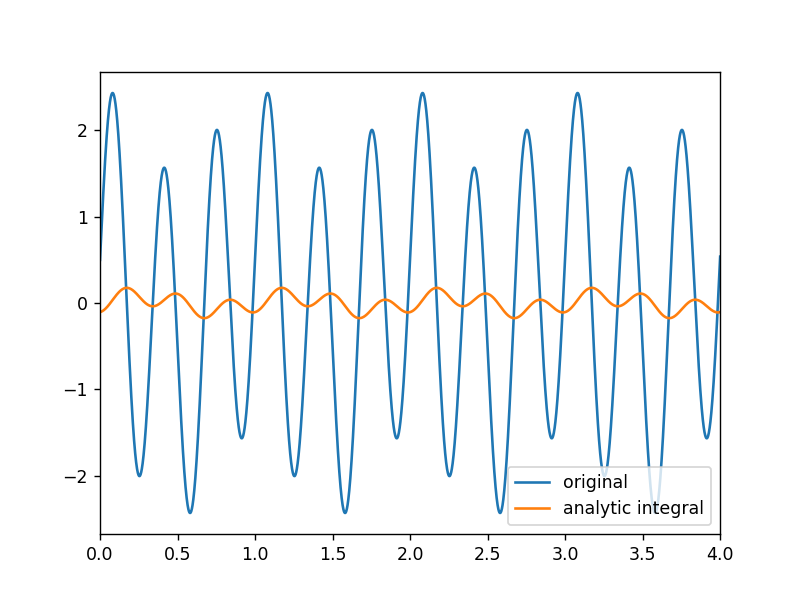

In [7]:
# Create some harmonic signals
dt = 0.001
fs = 1/dt
t = np.arange(0, 360, dt)
s = 2*np.sin(3*2*np.pi*t) + 0.5*np.cos(2*np.pi*t)

# The analytical integral
sa = 2/(3*2*np.pi) * -np.cos(3*2*np.pi*t) + 0.5/(2*np.pi) * np.sin(2*np.pi*t)

plt.figure()
plt.plot(t, s, label='original')
plt.plot(t, sa, label='analytic integral')
plt.xlim(0, 4)
plt.legend()


<IPython.core.display.Javascript object>


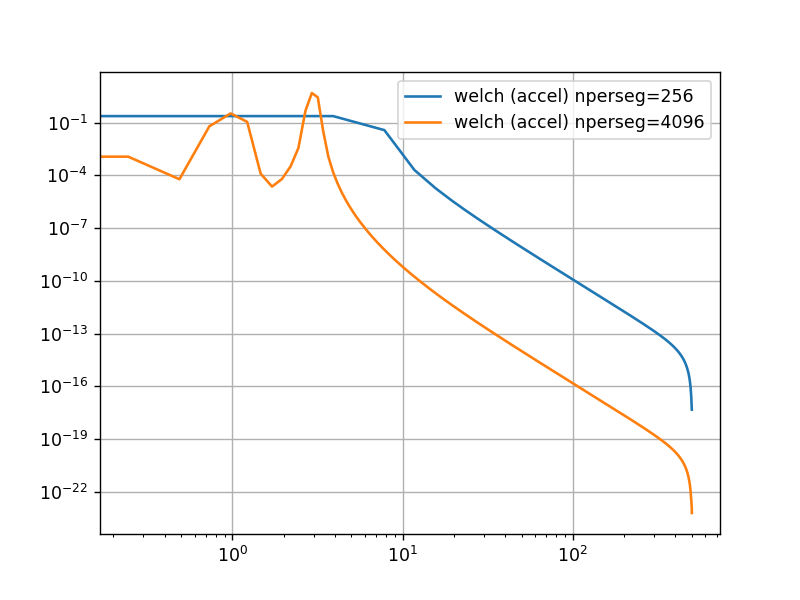

In [12]:
# Calculate the welch spectra

f2, Px256 = scipy.signal.welch(s, fs=fs, nperseg=256)
f4, Px = scipy.signal.welch(s, fs=fs, nperseg=4096)

plt.figure()
plt.loglog(f2, Px256, label='welch (accel) nperseg=256')
plt.loglog(f4, Px, label='welch (accel) nperseg=4096')
plt.grid()
plt.legend()

We expect two peaks, one at 1 Hz and one at 3 Hz. They are first visible when a sufficiently high number of samples are included in each segment.

In [13]:
# Add noise to signal.
noise = np.random.normal(0, 0.2, len(t))
sn = s + noise

<IPython.core.display.Javascript object>


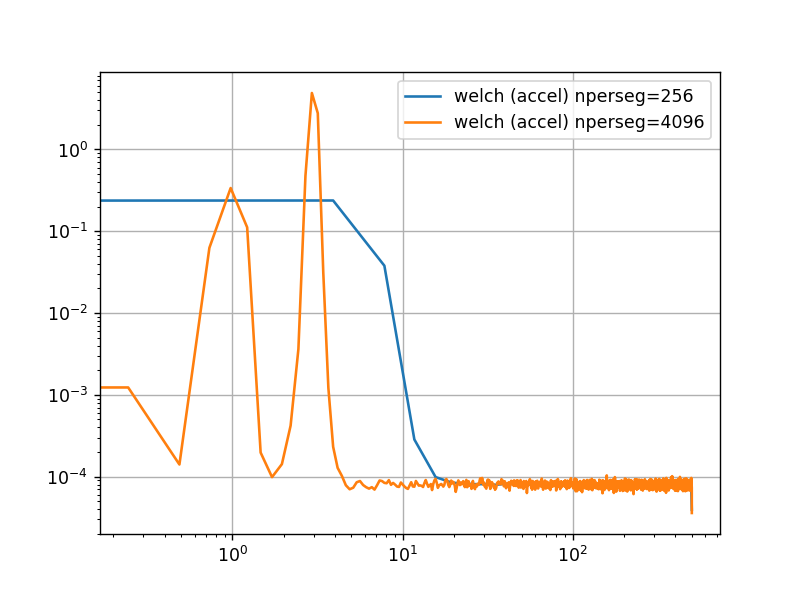

In [15]:
# Calculate the welch spectra of the noisy data

f2n, Px256n = scipy.signal.welch(sn, fs=fs, nperseg=256)
f4n, Pxn = scipy.signal.welch(sn, fs=fs, nperseg=4096)

plt.figure()
plt.loglog(f2n, Px256n, label='welch (accel) nperseg=256')
plt.loglog(f4n, Pxn, label='welch (accel) nperseg=4096')
plt.grid()
plt.legend()

Integrating the Welch spectra is done by multiplying it with $1/(\omega^4$ or $1/(2  \pi f)^4$.

/tmp/ipykernel_4843/3274635478.py:2: RuntimeWarning: divide by zero encountered in divide
  return P * (1/(2*np.pi*f)**4)


<IPython.core.display.Javascript object>


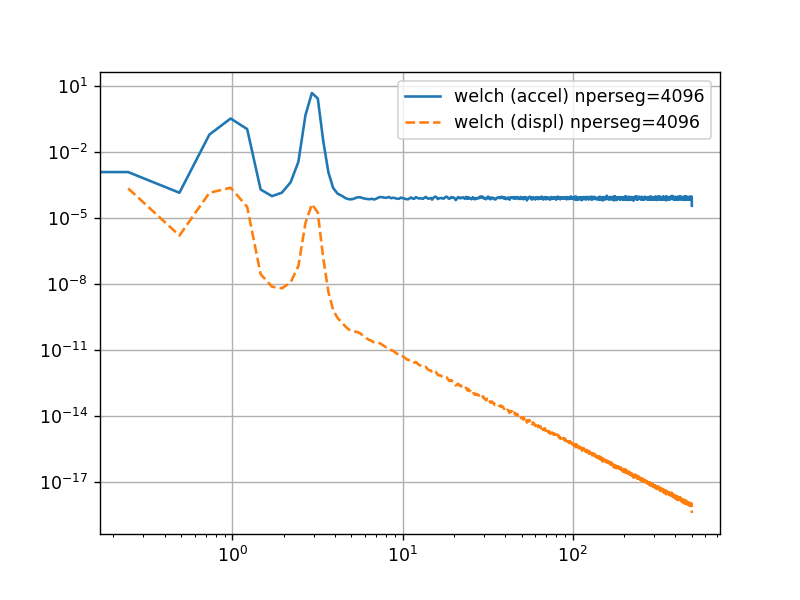

In [21]:
def welch_int(f, P):
    return P * (1/(2*np.pi*f)**4)

PxnI = welch_int(f4n, Pxn)

plt.figure()
plt.loglog(f4n, Pxn, label='welch (accel) nperseg=4096')
plt.loglog(f4n, PxnI, '--', label='welch (displ) nperseg=4096')
plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


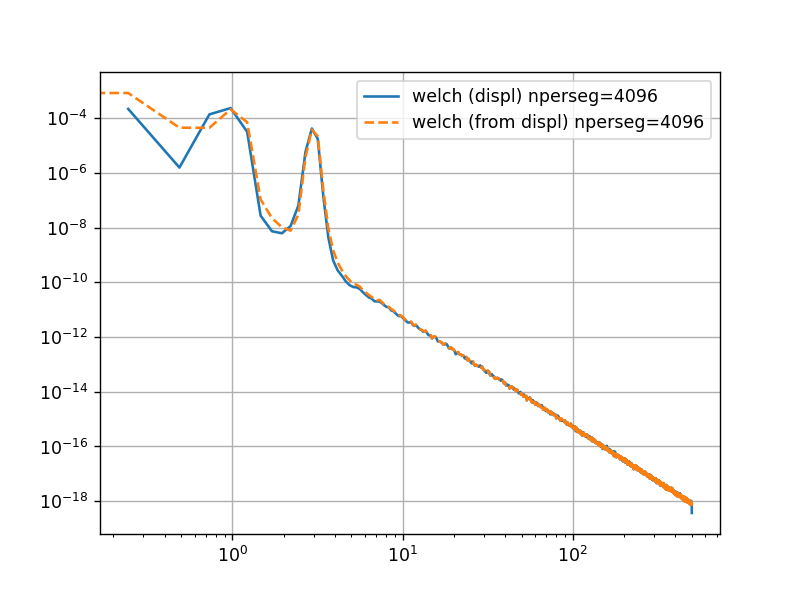

In [24]:
# Ideally this should be similar to first integrating the signal and then taking the Welch spectrum

def dft_integrate(x, fs):
    """
    Integrate in the Fourier domain. See Brandt & Brincker (2014) for a comparsion with the trapezoidal rule.
    """

    L = len(x)
    N = 2 * L  # x should be padded to avoid cyclic aliasing, achieved through taking the DFT at 2*L.

    X = np.fft.rfft(x, N)

    ## Integrator operator
    f = np.fft.rfftfreq(N, d=1. / fs)
    w = 2. * np.pi * f
    H = np.empty(shape=w.shape, dtype=complex)
    H[1:] = 1. / (1j * w[1:])
    H[0] = 0.

    ## Integrate
    Y = X * H

    y = np.fft.irfft(Y)
    y = y[:L]

    return y

sd = dft_integrate(sn - np.mean(sn), fs)
sd = dft_integrate(sd - np.mean(sd), fs)

fd, Pxd = scipy.signal.welch(sd, fs, nperseg=4096)

plt.figure()

plt.loglog(f4n, PxnI, label='welch (displ) nperseg=4096')
plt.loglog(fd, Pxd, '--', label='welch (from displ) nperseg=4096')
plt.grid()
plt.legend()

That looks promising. It looks like by integrating to displacement first we get less clear features at lower frequencies.